# Importing Necessary Libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import auc, accuracy_score, confusion_matrix
from sklearn.metrics import accuracy_score,classification_report
import seaborn as sns

import os
import io
import boto3
import json
import csv
from io import StringIO
import sagemaker

# Load Endpoint and Key for Input

In [2]:
sagemaker = boto3.client('sagemaker')
ENDPOINT_NAME = 'xgb-linsearch-20221106-15-35-44-002-cbc0d7a3'
runtime= boto3.client('runtime.sagemaker')
bucket = 'generic-data-bucket-zero'
s3 = boto3.client('s3')
key = 'test_set.csv'

# Reading Input and Gathering Predictions into Csv

In [3]:
response = s3.get_object(Bucket=bucket, Key=key)
content = response['Body'].read().decode('utf-8')
results = []
for line in  content.splitlines():
    response = runtime.invoke_endpoint(EndpointName=ENDPOINT_NAME,
                                            ContentType='text/csv',
                                            Body=line)
    result = json.loads(response['Body'].read().decode())
    results.append(result)
    i = 0
multiLine = ""
for item in results:
    if (i > 0):
        multiLine = multiLine + '\n'
    multiLine = multiLine + str(item)
    i+=1

file_name = "predictions.csv"
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, file_name).put(Body=multiLine)

{'ResponseMetadata': {'RequestId': 'QQV2EVB070D2ANHB',
  'HostId': '6Kmr5WOCRk2kbm1l2b8pqpjg41ir60P8H389EVSSXJRnvvAqoF5xu2l+dDJHw9FXDwvpR+lMsge9huhzo7F5uQ==',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '6Kmr5WOCRk2kbm1l2b8pqpjg41ir60P8H389EVSSXJRnvvAqoF5xu2l+dDJHw9FXDwvpR+lMsge9huhzo7F5uQ==',
   'x-amz-request-id': 'QQV2EVB070D2ANHB',
   'date': 'Sun, 06 Nov 2022 15:58:29 GMT',
   'x-amz-version-id': 'ovohYvwibV1vBEim2crDLZIwDKEcuDVU',
   'etag': '"00b568b0164eb60b55fbf3cae9448da3"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"00b568b0164eb60b55fbf3cae9448da3"',
 'VersionId': 'ovohYvwibV1vBEim2crDLZIwDKEcuDVU'}

# Reading in Predictions 

In [4]:
object_key = 'predictions.csv'
csv_obj = s3.get_object(Bucket=bucket, Key=object_key)
body = csv_obj['Body']
csv_string = body.read().decode('utf-8')

predictions_array = pd.read_csv(StringIO(csv_string))

# Reading in Target to Test Accuracy

In [5]:
object_key = 'test_target.csv'
csv_obj = s3.get_object(Bucket=bucket, Key=object_key)
body = csv_obj['Body']
csv_string = body.read().decode('utf-8')

test = pd.read_csv(StringIO(csv_string))

# Visualizing Accuracy of Model Endpoint

Text(0.5, 257.44, 'Predicted label')

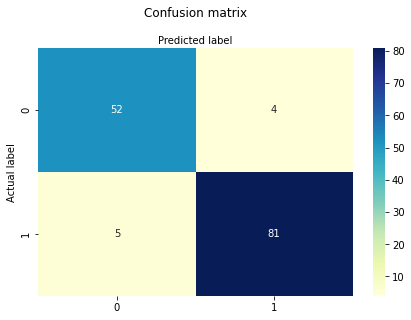

In [6]:
cm = metrics.confusion_matrix(test ,np.round(predictions_array))
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [7]:
print(classification_report(test , np.round(predictions_array)))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92        56
           1       0.95      0.94      0.95        86

    accuracy                           0.94       142
   macro avg       0.93      0.94      0.93       142
weighted avg       0.94      0.94      0.94       142



# Cleanup: Deleting Endpoint and Contents of Bucket

In [8]:
# Deleting Endpoint
sagemaker.delete_endpoint(EndpointName=ENDPOINT_NAME)

{'ResponseMetadata': {'RequestId': '1ab59a9e-f0a5-4363-b89e-9f4318889c59',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '1ab59a9e-f0a5-4363-b89e-9f4318889c59',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Sun, 06 Nov 2022 15:58:42 GMT'},
  'RetryAttempts': 0}}

In [9]:
bucket_to_delete = boto3.resource('s3').Bucket(bucket)
bucket_to_delete.objects.all().delete()

[{'ResponseMetadata': {'RequestId': 'Y1PYVSF6V9G6R13W',
   'HostId': 'll+qRkRbXCqxgZMc2ILlMxKpiTaDmAbXpDOsdb4z7RfOnNmNYAx+/h3vs33qqoAPCYasqvu+xs0=',
   'HTTPStatusCode': 200,
   'HTTPHeaders': {'x-amz-id-2': 'll+qRkRbXCqxgZMc2ILlMxKpiTaDmAbXpDOsdb4z7RfOnNmNYAx+/h3vs33qqoAPCYasqvu+xs0=',
    'x-amz-request-id': 'Y1PYVSF6V9G6R13W',
    'date': 'Sun, 06 Nov 2022 15:58:46 GMT',
    'content-type': 'application/xml',
    'transfer-encoding': 'chunked',
    'server': 'AmazonS3',
    'connection': 'close'},
   'RetryAttempts': 0},
  'Deleted': [{'Key': 'sagemaker/xgboost-breast-cancer-data/output/xgb-linsearch-20221106-15-35-44-005-d5191e12/output/model.tar.gz',
    'DeleteMarker': True,
    'DeleteMarkerVersionId': 'uLW8apKlCrupW0ywdnuzn6AcP4wYbU84'},
   {'Key': 'sagemaker/xgboost-breast-cancer-data/train/train.csv',
    'DeleteMarker': True,
    'DeleteMarkerVersionId': 'bLsmRIsIARn4bZHslrfOqdT.ECIsTknz'},
   {'Key': 'sagemaker/xgboost-breast-cancer-data/output/xgb-linsearch-20221106-15-35-